# Prototype: alpha

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `4000`|
| *Adversarial Attack* | `FGSM` |
| *Explanations* | `SHAP` |
| *Detector* | `Detect Adversarial Samples` |


---

In [1]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [2]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 2000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size, 42)
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Wednesday-workingHours.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (4000, 79)
--- Splittin

## Split Data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 70) (800, 70) (3200, 2) (800, 2)


## Create IDS

In [29]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

Epoch 1/10


2025-03-19 11:11:08.732864: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7570 - loss: 0.6516 - val_accuracy: 0.8672 - val_loss: 0.5496
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8990 - loss: 0.5063 - val_accuracy: 0.9719 - val_loss: 0.3589
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9697 - loss: 0.3117 - val_accuracy: 0.9812 - val_loss: 0.1787
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9738 - loss: 0.1547 - val_accuracy: 0.9812 - val_loss: 0.0860
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9742 - loss: 0.0888 - val_accuracy: 0.9844 - val_loss: 0.0589
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.0704 - val_accuracy: 0.9859 - val_loss: 0.0497
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9792 - loss: 0.0630 - val_accuracy: 0.9906 - val_loss: 0.0432
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9802 - loss: 0.0582 - val_accuracy: 0.9922 - val_loss: 0.0377
Ep

## Generate Attacks

In [5]:
import functions.attack_generator as ag
import importlib
importlib.reload(ag)

# fit art model with all features
all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, all_features)

X_adv_fgsm = ag.generate_fgsm_attacks(art_model, X_train)
print(X_adv_fgsm.iloc[:, :3].head(2))

_ = ag.evaluate_art_model(art_model, X_adv_fgsm, y_train)

Adversarial FGSM examples generated. Shape: (3200, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.101221            0.0           0.000000
1          0.000000            0.0           0.100064
Accuracy: 19.03%
              precision    recall  f1-score   support

      BENIGN       0.13      0.11      0.12      1622
      ATTACK       0.23      0.27      0.25      1578

    accuracy                           0.19      3200
   macro avg       0.18      0.19      0.19      3200
weighted avg       0.18      0.19      0.18      3200

Confusion Matrix: Positive == BENIGN
TN: 176, FP: 1446, FN: 1145, TP: 433


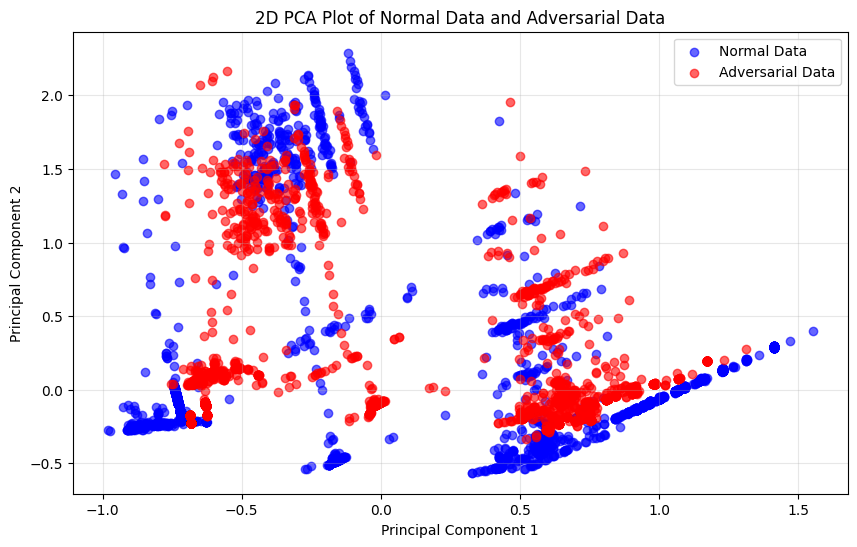

In [6]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train, 'Normal Data', X_adv_fgsm, 'Adversarial Data')

## Explainer

In [ ]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values_df = exp.generate_shap_values(explainer, X_train)
print(shap_values_df.shape)

shap_values_adv_df = exp.generate_shap_values(explainer, X_adv_fgsm)
print(shap_values_adv_df.shape)

PermutationExplainer explainer: 3201it [03:50, 13.75it/s]                          


(3200, 70)


PermutationExplainer explainer: 3201it [03:29, 14.63it/s]                          

(3200, 70)


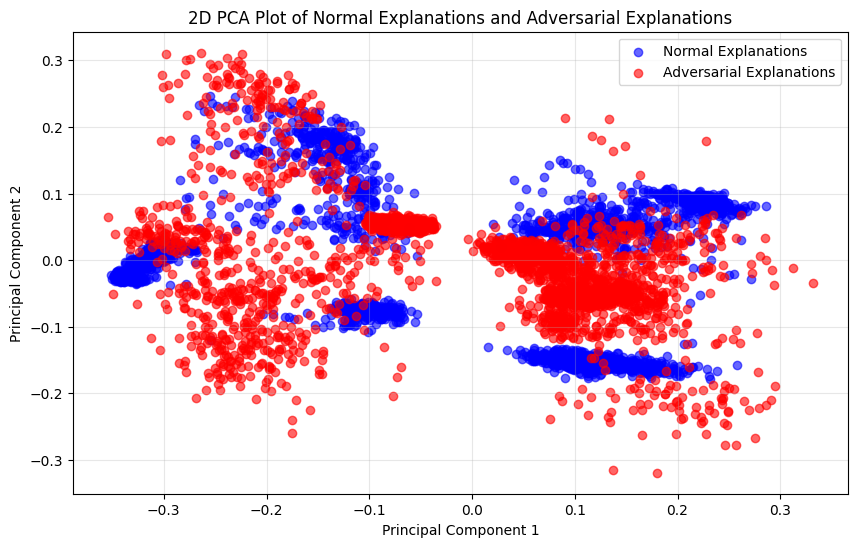

In [8]:
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

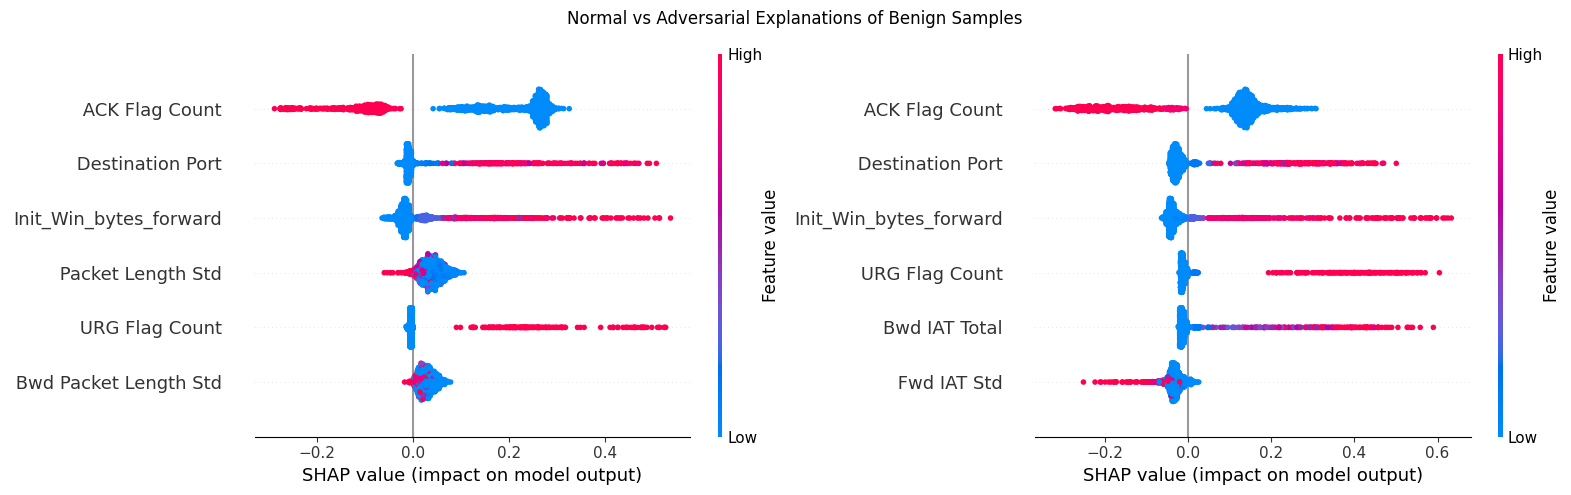

In [ ]:
import numpy as np
# find benign samples
benign_samples = np.where(y_train['BENIGN'] == 1)
exp.plot_shap_summary_comparison(shap_values_df.values, X_train, shap_values_adv_df.values, X_adv_fgsm, 6, target_indices=benign_samples, title='Normal vs Adversarial Explanations of Benign Samples')

## Detector

In [28]:
import functions.detector as det
import importlib
importlib.reload(det)
import numpy as np

# create dataframe
X, y = det.build_train_datasets(shap_values_df, shap_values_adv_df)
print(X.shape, y.shape)

# create normalizer
# normalizer = det.create_min_max_normalizer(X)
# print(np.max(normalizer.data_max_))
# print(np.min(normalizer.data_min_))

# TODO: how to normalize? min/max should be consistent for all datasets
# normalize features
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)


# normalizer_adv = det.create_min_max_normalizer(shap_values_adv_df)
# print(np.max(normalizer_adv.data_max_))
# print(np.min(normalizer_adv.data_min_))

# shap_values_normalized = det.normalize_shap_values(shap_values_df)
# print(shap_values_normalized.shape)
# print(np.max(shap_values_normalized))
# print(np.min(shap_values_normalized))

(6400, 70) (6400, 2)
(5760, 70) (640, 70) (5760, 2) (640, 2)
Epoch 1/10


2025-03-19 11:10:27.177216: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6123 - loss: 0.6859 - val_accuracy: 0.8819 - val_loss: 0.6500
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8211 - loss: 0.6251 - val_accuracy: 0.9410 - val_loss: 0.4837
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9059 - loss: 0.4370 - val_accuracy: 0.9783 - val_loss: 0.2154
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9528 - loss: 0.2265 - val_accuracy: 0.9835 - val_loss: 0.1030
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9689 - loss: 0.1431 - val_accuracy: 0.9887 - val_loss: 0.0667
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9803 - loss: 0.0961 - val_accuracy: 0.9896 - val_loss: 0.0479
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9845 - loss: 0.0682 - val_accuracy: 0.9922 - val_loss: 0.0346
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 0.0479 - val_accuracy: 0.9922 - val_loss: 0.0252
Ep

---
## Test Process

In [11]:
print(X_test.shape)

(800, 70)


### Generate Attacks

In [12]:
X_test_adv = ag.generate_fgsm_attacks(art_model, X_test)

Adversarial FGSM examples generated. Shape: (800, 70)


### Generate Explanations

In [ ]:
X_test_adv_shap_values_df = exp.generate_shap_values(explainer, X_test_adv)
X_test_shap_values_df = exp.generate_shap_values(explainer, X_test)

PermutationExplainer explainer: 801it [00:57, 11.79it/s]                         
PermutationExplainer explainer: 801it [01:02, 10.67it/s]                         


### Generate Datasets

In [14]:
X, y = det.build_train_datasets(X_test_shap_values_df, X_test_adv_shap_values_df)

### Shuffle Data & Predict

In [15]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

y_pred = detector.predict(X)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Evaluate

In [16]:
det.evaluate_model(y_pred, y)

Global Accuracy: 99.62%
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00       800
 ADVERSARIAL       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

True Negative Rate: 99.50%
False Positive Rate: 0.50%
True Positive Rate: 99.75%
False Negative Rate: 0.25%


---
## Additional Evaluation - New Samples

In [17]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, _ = dp.preprocess_data(dataset_excluded, encoding_type, normalizer, zero_columns, sample_size=500, random_sample_state=17)
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (1000, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      500
True    False     500
Name: count, dtype: int64


In [ ]:
X_adv_fgsm_eval = ag.generate_fgsm_attacks(art_model, X_eval)
print(X_adv_fgsm_eval.iloc[:, :3].head(2))

y_pred_adv = ag.evaluate_art_model(art_model, X_adv_fgsm_eval, y_eval)

Adversarial FGSM examples generated. Shape: (1000, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.101221            0.0           0.000000
1          0.000000            0.0           0.100064
Accuracy: 20.40%
              precision    recall  f1-score   support

      BENIGN       0.13      0.11      0.12       500
      ATTACK       0.25      0.30      0.27       500

    accuracy                           0.20      1000
   macro avg       0.19      0.20      0.20      1000
weighted avg       0.19      0.20      0.20      1000

Confusion Matrix: Positive == BENIGN
TN: 54, FP: 446, FN: 350, TP: 150


In [ ]:
X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_fgsm_eval)
X_eval_shap_values_df = exp.generate_shap_values(explainer, X_eval)

PermutationExplainer explainer: 1001it [01:05, 12.70it/s]                          
PermutationExplainer explainer: 1001it [01:13, 11.71it/s]                          


In [20]:
X_eval_detector, y_eval_detector = det.build_train_datasets(X_eval_shap_values_df, X_eval_adv_shap_values_df)
print(X_eval_detector.shape, y_eval_detector.shape)

(2000, 70) (2000, 2)


In [27]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-03-19 11:10:11.281974: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [22]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 99.35%
              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99      1000
 ADVERSARIAL       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

True Negative Rate: 99.40%
False Positive Rate: 0.60%
True Positive Rate: 99.30%
False Negative Rate: 0.70%
